
# Task 2: Quantitative Analysis with TA-Lib and PyNance 
## Objectives:
- Load & prepare OHLCV data
- Compute technical indicators (SMA, EMA, RSI, MACD, ATR, Bollinger Bands) using TA-Lib
- Compute Sharpe ratio, Value at Risk placeholder
- Visualize price, indicators, and performance

## KPIs:
- Accuracy of indicators
- Completeness of Data Analysis

# Imports, Constants, and Path Definitions 

In [146]:
import os
import sys
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.subplots as psub
import plotly.io as pio

print("Default renderer:", pio.renderers.default)
pio.renderers.default = "notebook"

## Setup Pathz
notebook_dir = Path.cwd()
project_root = notebook_dir.parent.parent
scripts_path = project_root / 'scripts'
scripts_path_str = str(scripts_path)
if scripts_path_str not in sys.path:
    sys.path.insert(0, scripts_path_str)

# Local modules
from data_loader import DataLoader
from quant_analysis import QuantAnalysis, MovingAverageConfig, MACDConfig, RSIConfig, ATRConfig, BollingerBandsConfig


plt.style.use("seaborn-v0_8")
sns.set_context("talk")
TICKERS = ["AAPL", "AMZN", "MSFT", "NVDA","GOOG", "META"]
DATA_DIR = Path("../data")
PRICE_PATH = DATA_DIR / f"{TICKERS[5]}.csv"

Default renderer: notebook


## 1. Load & Prepare Data

In [147]:
loader = DataLoader()
price_df = loader.load_stock_price(PRICE_PATH, preview=False)
price_df.head()
### Basic inspection
print("Columns:", price_df.columns.tolist())
print(price_df.select_dtypes(include="number").describe())

Columns: ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
             Close         High          Low         Open        Volume
count  2923.000000  2923.000000  2923.000000  2923.000000  2.923000e+03
mean    156.727440   158.690484   154.685098   156.653626  3.060615e+07
std      90.368766    91.470736    89.222981    90.308834  2.637157e+07
min      17.621368    18.158061    17.442471    17.969224  5.467500e+06
25%      80.275124    80.970839    79.663892    80.275126  1.633730e+07
50%     152.579376   154.636700   150.730785   152.698669  2.295390e+07
75%     203.550171   206.372783   200.548679   202.963782  3.522740e+07
max     379.838379   381.975166   376.488998   379.341431  5.735764e+08


## 2. Add Technical Indicators

In [148]:
# Selectively enabling indicators by passing configs.
qa = QuantAnalysis(periods_per_year=252)
price_ind_df = qa.add_indicators(
    price_df,
    prefix="TA_",
    ma_cfg=MovingAverageConfig(sma_period=20, ema_period=20),
    rsi_cfg=RSIConfig(period=14),
    macd_cfg=MACDConfig(fast=12, slow=26, signal=9),
    atr_cfg=ATRConfig(period=14),
    bbands_cfg=BollingerBandsConfig(period=20, nbdevup=2.0, nbdevdn=2.0, matype=0),
)
price_ind_df.tail()

,Date,Close,High,Low,Open,Volume,TA_SMA_20,TA_EMA_20,TA_RSI_14,TA_MACD,TA_MACD_signal,TA_MACD_hist,TA_ATR_14,TA_BB_upper,TA_BB_mid,TA_BB_lower
2918,2023-12-22,351.224823,355.011477,349.068105,353.401377,11772800,332.302945,335.581703,67.333885,6.945367,4.729907,2.215461,8.062285,354.085026,332.302945,310.520864
2919,2023-12-26,352.655975,354.792827,351.284456,352.814999,9898600,333.303278,337.207824,68.187000,7.436800,5.271285,2.165514,7.741265,356.825215,333.303278,309.781340
2920,2023-12-27,355.637543,356.800387,353.132994,353.888347,13207900,334.239505,338.963036,69.947874,7.974921,5.812012,2.162908,7.484347,359.674389,334.239505,308.804621
2921,2023-12-28,356.124634,359.682686,355.617749,357.496184,11798800,335.537503,340.597473,70.237702,8.344500,6.318510,2.025990,7.240104,362.605290,335.537503,308.469716
2922,2023-12-29,351.791290,357.794292,349.664418,356.790470,14987100,336.869788,341.663551,64.296803,8.193282,6.693464,1.499818,7.303659,364.379857,336.869788,309.359718


## 3. Compute Returns & Performance Metrics

In [149]:
price_ret_df = qa.compute_returns(price_ind_df, method="simple")

sharpe = qa.sharpe_ratio(price_ret_df)
sortino = qa.sortino_ratio(price_ret_df)
mdd = qa.max_drawdown(price_ret_df)
calmar = qa.calmar_ratio(price_ret_df)

metrics = {
    "Sharpe (annualized)": sharpe,
    "Sortino (annualized)": sortino,
    "Max Drawdown": mdd,
    "Calmar": calmar,
}
metrics

{'Sharpe (annualized)': 0.679478693355387,
 'Sortino (annualized)': 0.9056258017511315,
 'Max Drawdown': -0.767360903556843,
 'Calmar': 10.762469283137428}

## 4. Visualizations

## SMA & EMA

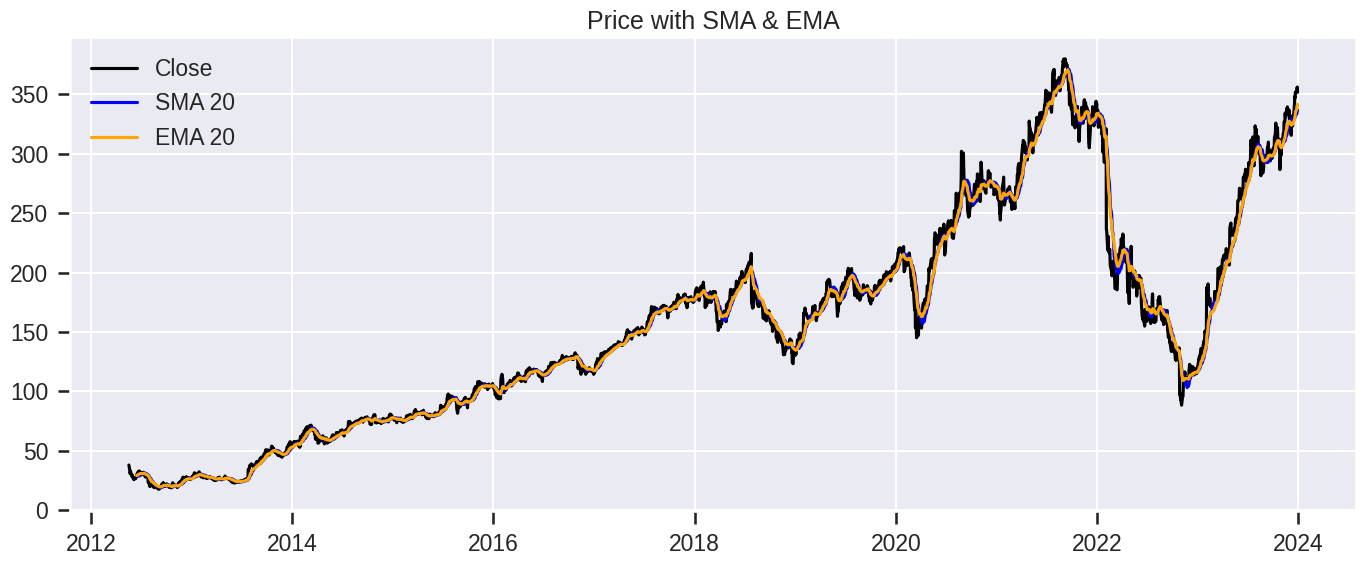

In [150]:
fig, ax = plt.subplots(figsize=(14,6))
ax.plot(price_ret_df["Date"], price_ret_df["Close"], label="Close", color="black")
ax.plot(price_ret_df["Date"], price_ret_df["TA_SMA_20"], label="SMA 20", color="blue")
ax.plot(price_ret_df["Date"], price_ret_df["TA_EMA_20"], label="EMA 20", color="orange")
ax.set_title("Price with SMA & EMA")
ax.legend()
plt.tight_layout()
plt.show()

## RSI

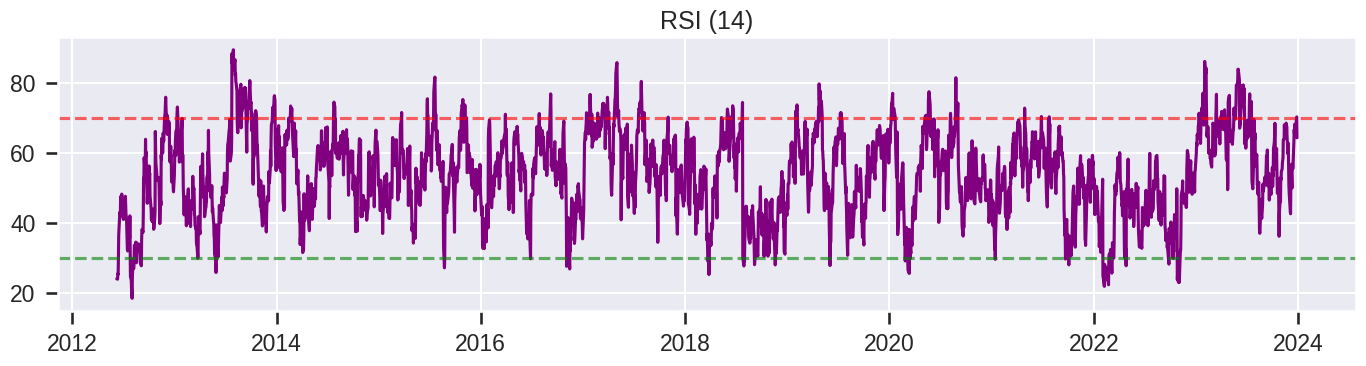

In [151]:
plt.figure(figsize=(14,4))
plt.plot(price_ret_df["Date"], price_ret_df["TA_RSI_14"], color="purple")
plt.axhline(70, color="red", linestyle="--", alpha=0.6)
plt.axhline(30, color="green", linestyle="--", alpha=0.6)
plt.title("RSI (14)")
plt.tight_layout()
plt.show()

## MACD Interactive

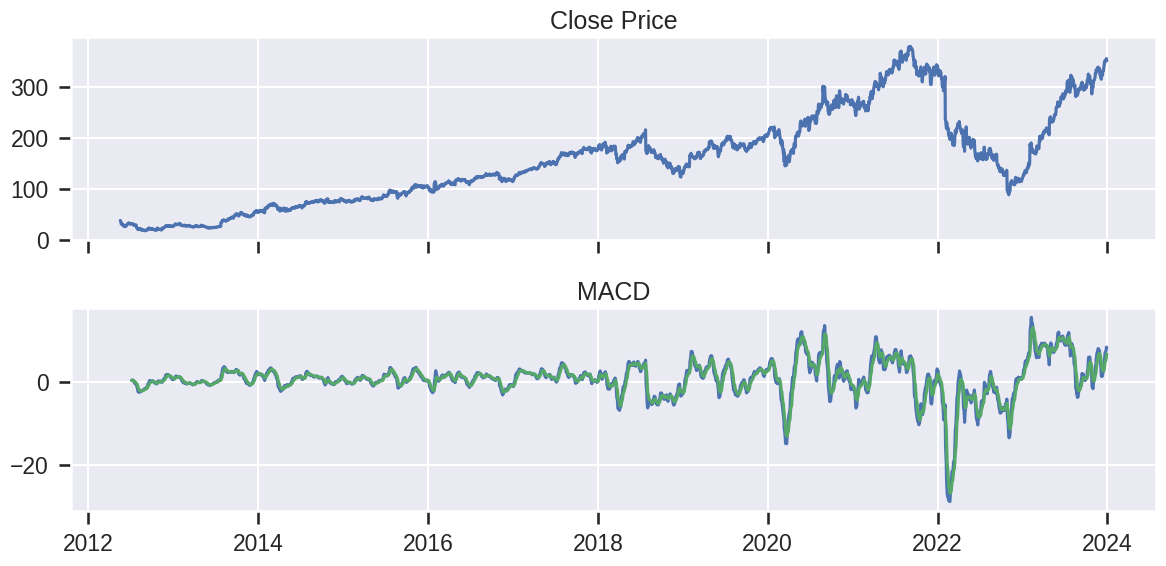

In [152]:
#  Uncomment for interactive version
# fig = psub.make_subplots(rows=2, cols=1, shared_xaxes=True, row_heights=[0.6, 0.4])
# fig.add_trace(go.Scatter(x=price_ret_df["Date"], y=price_ret_df["Close"], name="Close", line=dict(color="black")), row=1, col=1)
# fig.add_trace(go.Scatter(x=price_ret_df["Date"], y=price_ret_df["TA_MACD"], name="MACD", line=dict(color="purple")), row=2, col=1)
# fig.add_trace(go.Scatter(x=price_ret_df["Date"], y=price_ret_df["TA_MACD_signal"], name="Signal", line=dict(color="orange")), row=2, col=1)
# fig.update_layout(height=600, title="Price & MACD")
# fig.show()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

ax1.plot(price_ret_df["Date"], price_ret_df["Close"])
ax1.set_title("Close Price")

ax2.plot(price_ret_df["Date"], price_ret_df["TA_MACD"])
ax2.plot(price_ret_df["Date"], price_ret_df["TA_MACD_signal"])
ax2.set_title("MACD")

plt.tight_layout()
plt.savefig("macd_static.png")
plt.show()

## Bollinger Bands

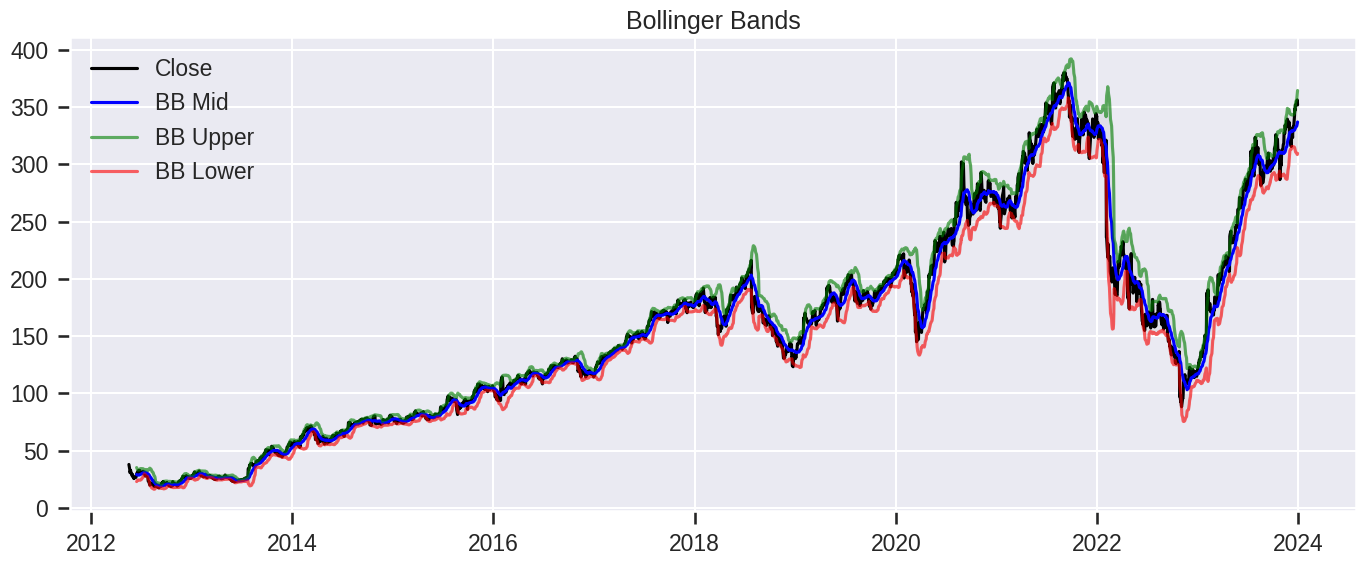

In [153]:
plt.figure(figsize=(14,6))
plt.plot(price_ret_df["Date"], price_ret_df["Close"], label="Close", color="black")
plt.plot(price_ret_df["Date"], price_ret_df["TA_BB_mid"], label="BB Mid", color="blue")
plt.plot(price_ret_df["Date"], price_ret_df["TA_BB_upper"], label="BB Upper", color="green", alpha=0.6)
plt.plot(price_ret_df["Date"], price_ret_df["TA_BB_lower"], label="BB Lower", color="red", alpha=0.6)
plt.fill_between(price_ret_df["Date"], price_ret_df["TA_BB_lower"], price_ret_df["TA_BB_upper"], color="gray", alpha=0.1)
plt.title("Bollinger Bands")
plt.legend()
plt.tight_layout()
plt.show()

## Cumulative Return & Drawdown

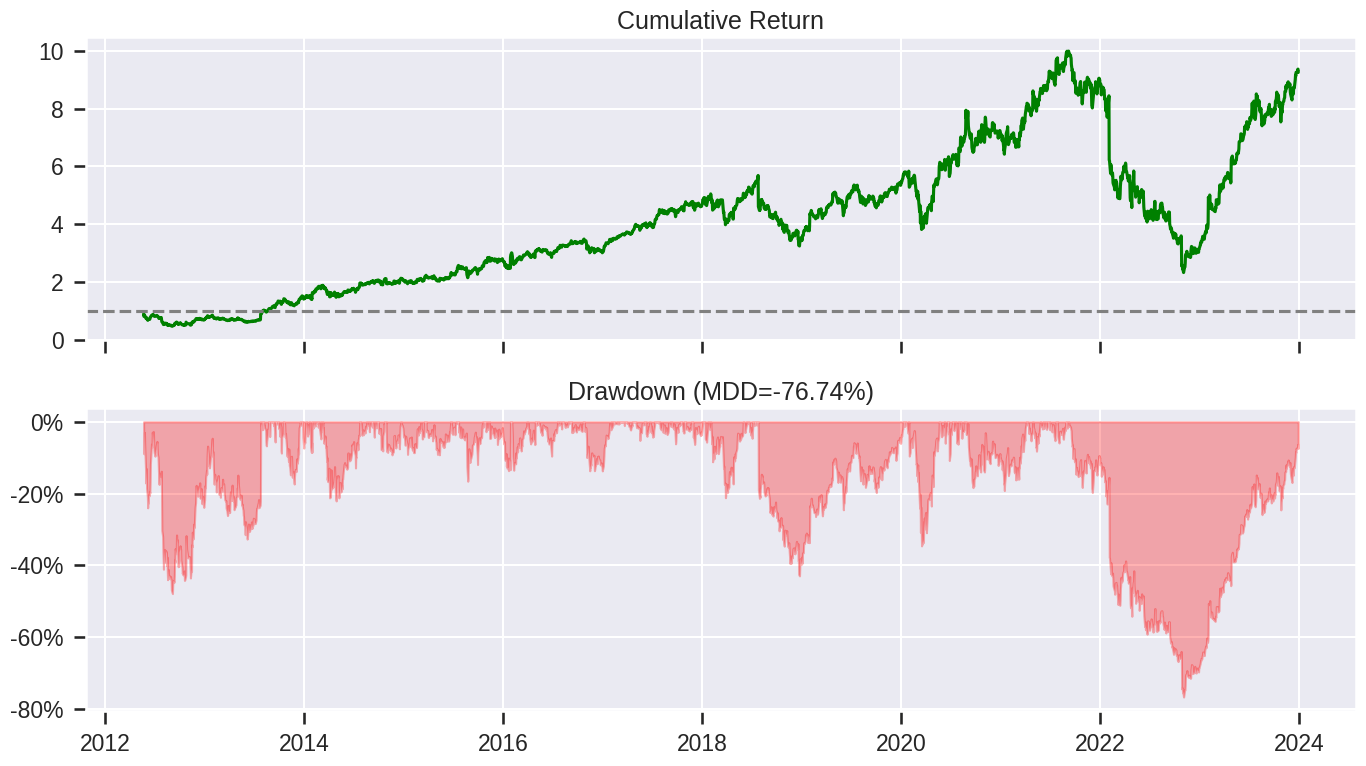

In [154]:
equity = price_ret_df["cumulative_return"]
running_max = equity.cummax()
drawdown = (equity - running_max) / running_max

fig, axes = plt.subplots(2, 1, figsize=(14,8), sharex=True)
axes[0].plot(price_ret_df["Date"], equity, color="green")
axes[0].set_title("Cumulative Return")
axes[0].axhline(1.0, color="gray", linestyle="--")

axes[1].fill_between(price_ret_df["Date"], drawdown, 0, color="red", alpha=0.3)
axes[1].set_title(f"Drawdown (MDD={mdd:.2%})")
axes[1].yaxis.set_major_formatter(lambda v, pos: f"{v:.0%}")
plt.tight_layout()
plt.show()

## 5. Export

In [155]:
price_ret_df["ticker"] = f"{TICKERS[5]}"
price_ret_df.to_csv(f"../data/{TICKERS[5]}_task2_price_indicators.csv", index=False)